# Introduction
We will use Markov Chain Monte Carlo to estimate the parameters of a mixture model. The true probability density function will be
$$
f(x) = \frac{0.6}{\sqrt{2\pi}}\exp\left[-\frac{x^2}{2}\right] + \frac{0.4}{\sqrt{2\pi}}\exp\left[-\frac{\left(x - 4\right)^2}{2}\right]
$$
for this exercise, *i.e.* the distribution is a mixutre of two normals with parameters
$$
\mu_1 = 0,\quad \sigma_1 = \sigma = 1,\quad \mu_2 = 4,\quad\text{and}\quad \sigma_2 = \sigma = 1.
$$
The probability density function $f$ will be used to generate $x_1, x_2,\ldots, x_n$. Our algorithm will use this data to estimate the parameters.

Initially, we will assume the distribution has probability density function of the form
$$
f(x) = \frac{\omega_1}{\sigma\sqrt{2\pi}}\exp\left[-\frac{1}{2}\left(\frac{x - \mu_1}{\sigma}\right)^2\right] + \frac{\omega_2}{\sigma\sqrt{2\pi}}\exp\left[-\frac{1}{2}\left(\frac{x - \mu_2}{\sigma}\right)^2\right].
$$
Our priors are that
* $\mu_k\sim{\mathcal{N(\eta = 0, \tau^2 = 16)}}$,
* $\sigma^2\sim{\text{InvGamma}(d = 2, q = 1)}$, and
* $\omega_1 \sim{Beta(a_1 = 1, a_2 = 1)}$.

This code was heavily influenced by R code from the UCSC Coursera course *Bayesian Statistics: Mixture Models*. Click [here](https://www.coursera.org/learn/mixture-models/supplement/HgGgw/sample-code-for-mcmc-example-1) for more details.


# Packages and Setup

In [1]:
# Import packages
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Enable LaTeX for plt graphs
plt.rcParams['text.usetex'] = True

In [2]:
# Set random seed
np.random.seed(0)

# Set true variables
K = 2
w_true = np.array([0.6, 0.4])
mu_true = np.array([0, 4])
sigma_true = 1
n = 100

# Randomly generate c_i values given probabilities w_true
c = np.random.choice(K, n, replace = True, p = w_true)

# Use c to generate data
x = np.array([stats.norm.rvs(loc = mu_true[c_i], scale = sigma_true, size = 1)[0] for c_i in c])    

Let us examine the true density function.

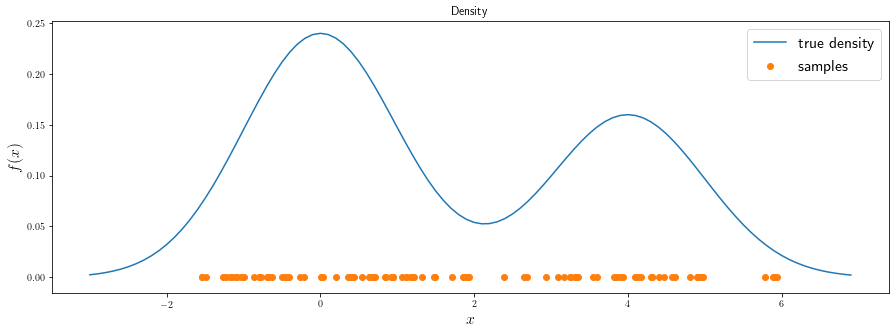

In [3]:
# Save array of default colors
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Define an array of x-values to be used for graphs
x_arr = np.arange(-3, 7, 0.10)

# Calculate true y-values of density function evaluated on x_arr
y_true = (w_true[0] * stats.norm.pdf(x_arr, loc = mu_true[0], scale = sigma_true) 
           + w_true[1] * stats.norm.pdf(x_arr, loc = mu_true[1], scale = sigma_true))

# Plot the true density graph and the samples
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x_arr, y_true, color = colors[0], label = 'true density')
ax.scatter(x, np.zeros(n), color = colors[1], label = 'samples')
ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

We will initialize the algorithm so that
* $\omega_1=\omega_2 = 0.5$,
* $\sigma = std(x_i)$, and
* $\mu_k = \bar{x_i} + (-1)^k std(x_i)$

The initialized parameter probability density function and the true density are ploted below. As can be seen, the initial distribution only has one mode unlike the bimodal true distribution. This is most likely because $\sigma$ for the true distribution is much smaller than the value in which it was initialized.

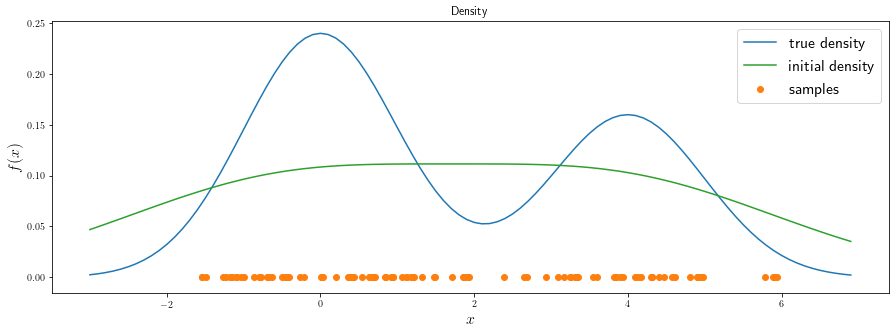

In [4]:
# Initialize values for algorithm 
w = np.array([0.5, 0.5])
sigma = np.std(x)
mu = np.array([np.mean(x) - sigma, np.mean(x) + sigma])

# Calculate y-values of pdf for graph
y_est = w[0] * stats.norm.pdf(x_arr, mu[0], sigma) + w[1] * stats.norm.pdf(x_arr, mu[1], sigma)

# Plot the initial estimate
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x_arr, y_true, color = colors[0], label = 'true density')
ax.plot(x_arr, y_est, color = colors[2], label = 'initial density')
ax.scatter(x, np.zeros(n), color = colors[1], label = 'samples')
ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

As mentioned in the introduction, we assume priors 
$$
\mu_k\sim{\mathcal{N(\eta = 0, \tau^2 = 16)}},\quad \sigma^2\sim{\text{InvGamma}(d = 2, q = 1)},\quad\text{and}\quad\omega_1 \sim{Beta(a_1 = 1, a_2 = 1)}.
$$

In [ ]:
# Prior distribution parameters
a = np.repeat(1, K)
eta = 0
tau = 4
d = 2
q = 1


The Markov Chain Monte Carlo algorithm is run below.

In [5]:
# Number of iterations and burn-in peroid
itrs = 11000
burn = 1000

# Initialize arrays
c_out = np.reshape(np.zeros(n * itrs), newshape = (itrs, n))
omega_out = np.reshape(np.zeros(K * itrs), newshape = (itrs, K))
mu_out = np.reshape(np.zeros(K * itrs), newshape = (itrs, K))
sigma_out = np.zeros(itrs)
logpost = np.zeros(itrs)

for s in range(itrs):
    
    # Initialize v
    v = np.reshape(np.zeros(n * K), newshape = (n, K))
    
    # Calculate values for v in this iteration 
    v[: , 0] = np.log(w[0]) + stats.norm.logpdf(x, loc = mu[0], scale = sigma)
    v[: , 1] = np.log(w[1]) + stats.norm.logpdf(x, loc = mu[1], scale = sigma)
    
    # Calculate max of each row
    v_max = np.reshape(np.max(v, axis = 1), newshape = (n, 1))
    
    # Calculate sum of each row
    v_sum = np.reshape(np.sum(np.exp(v - v_max), axis = 1), newshape = (n, 1))
    
    # Convert v-values to maintain numerical stability
    v = np.exp(v - v_max)/v_sum
    
    # Sample from {0, 1} with probability v[i, [0, 1]] to obtain c-values
    c = np.array([np.random.choice(K, 1, p = v[i, :])[0] for i in range(n)])
              
    # Sample from beta distribution to obtain omega_1
    w[0] = stats.beta.rvs(a[0] + np.sum(c == 0), a[1] + np.sum(c == 1))
    
    # omega_2 = 1 - omega_1
    w[1] = 1 - w[0]
    
    for k in range(K):
        
        # Calculate posteriors for parameters
        n_k = np.sum(c == k)
        sum_k = np.sum(x[c == k])
        tau2_hat = 1/(n_k/sigma**2 + 1/tau**2)
        mu_hat = tau2_hat * (sum_k/sigma**2 + eta/tau**2)
        mu[k] = stats.norm.rvs(loc = mu_hat, scale = np.sqrt(tau2_hat), size = 1)[0]
    
    # Sample the variances
    d_star = d + n/2
    q_star = q + np.sum((x - mu[c])**2)/2
    sigma = np.sqrt(stats.invgamma.rvs(a = d_star, scale = q_star))
    
    # Save resutls
    c_out[s, :] = c
    omega_out[s, :] = w
    mu_out[s, :] = mu
    sigma_out[s] = sigma
    
    # Record log likelihood
    logpost[s] = np.sum(np.log(w[c]) + stats.norm.logpdf(x, mu[c], sigma)) 
    logpost[s] += stats.beta.pdf(w[0], a[0], a[1])  
    logpost[s] += stats.norm.logpdf(mu[0], eta, tau) + stats.norm.logpdf(mu[1], eta, tau) 
    logpost[s] += stats.invgamma.pdf(sigma**2, d, 1/q)
        
    if s == itrs - 1:
        
        print('The algorithm has terminated!')


The algorithm has terminated!


# Results

As can be seen from the log likelihood graph for each iteration, the burn-in peroid is far less than 1000.

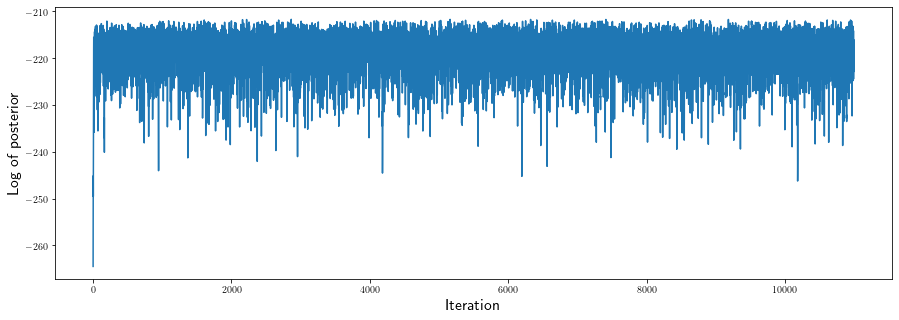

In [7]:
# Plot progress of Q each iteration
fig, ax = plt.subplots(figsize = (15, 5))

ax.plot(range(len(logpost)), logpost)
ax.set_xlabel(r'Iteration', fontsize = 16)
ax.set_ylabel('Log of posterior', fontsize = 16)
ax.set_title(r'')

plt.show()

A confidence interval for our estimated pdf, the median pdf, and the true pdf are shown in the graph below. Our results are weaker than the expectation maximization algorithm.

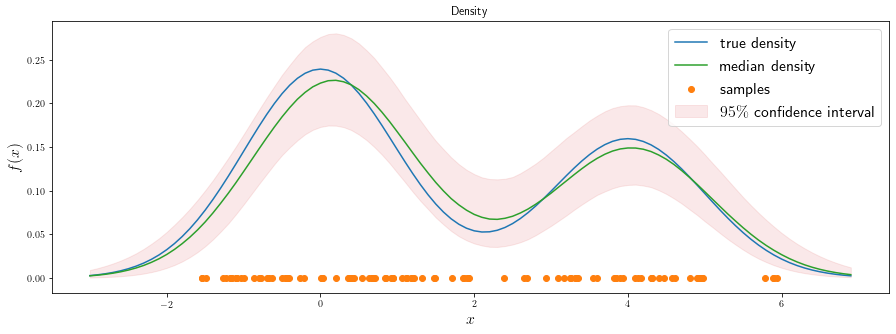

In [8]:
# Create array to have density functions evaluated at x_arr
den_pos = np.reshape(np.zeros((itrs - burn) * len(x_arr)), newshape = (itrs - burn, len(x_arr)))

for s in range(burn, itrs):
    
    den_pos[s - burn, :] = (omega_out[s, 0] * stats.norm.pdf(x_arr, loc = mu_out[s, 0], scale = sigma_out[s]) 
                            + omega_out[s, 1] * stats.norm.pdf(x_arr, loc = mu_out[s, 1], scale = sigma_out[s])) 
    

# Record 2.5-, 50, and 97.5-percentiles.
den_pos_l = np.quantile(den_pos, q = 0.025, axis = 0)
den_pos_m = np.quantile(den_pos, q = 0.500, axis = 0)
den_pos_u = np.quantile(den_pos, q = 0.975, axis = 0)

# Plot final estimate of density
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(x_arr, y_true, color = colors[0], label = 'true density')
ax.scatter(x, np.zeros(n), color = colors[1], label = 'samples')
ax.plot(x_arr, den_pos_m, color = colors[2], label = 'median density')
ax.fill_between(x_arr, den_pos_u, den_pos_l, color = colors[3], alpha = 0.10, 
                label = r'$95\%$ confidence interval')

ax.set_title('Density')
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$f(x)$', fontsize = 16)
ax.legend(fontsize = 16)

plt.show()

Lastly, we will plot our parameter estimates. We omit $\omega_2$ because $\omega_2 = 1 - \omega_1$.

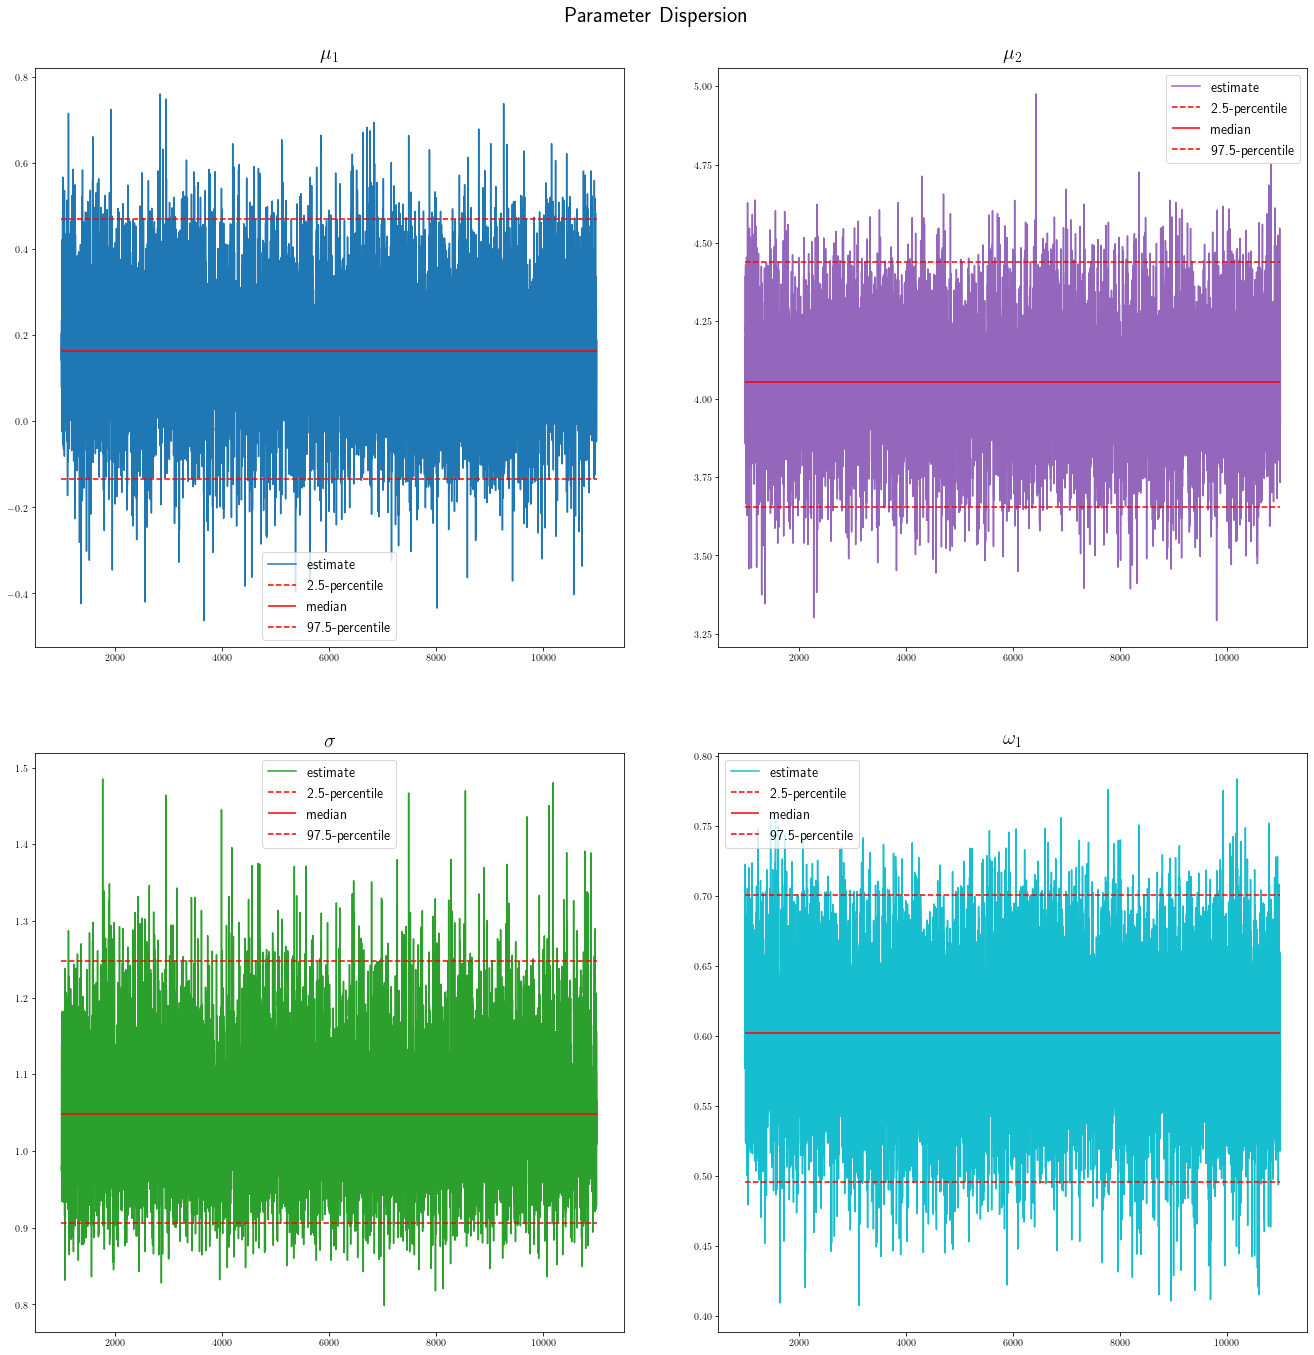

In [9]:
# Define function to get 2.5-, 50, and 97.5-percentiles.
rtn_stats = lambda arr: [np.quantile(arr, q = quant) for quant in [0.025, 0.5, 0.975]]

# Plot final estimate of density
fig, axs = plt.subplots(2, 2, figsize = (20, 20))

axs[0, 0].plot(range(burn, itrs), mu_out[burn: , 0], color = colors[0], label = r'estimate', zorder = 0)

# Use rtn_stats
mu_l, mu_m, mu_u = rtn_stats(mu_out[burn: , 0])

axs[0, 0].hlines(mu_l, xmin = burn, xmax = itrs, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[0, 0].hlines(mu_m, xmin = burn, xmax = itrs, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[0, 0].hlines(mu_u, xmin = burn, xmax = itrs, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[0, 0].set_title(r'$\mu_1$', fontsize = 20)
axs[0, 0].legend(fontsize = 14)

axs[0, 1].plot(range(burn, itrs), mu_out[burn: , 1], color = colors[4], label = r'estimate', zorder = 0)

# Use rtn_stats
mu_l, mu_m, mu_u = rtn_stats(mu_out[burn: , 1])

axs[0, 1].hlines(mu_l, xmin = burn, xmax = itrs, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[0, 1].hlines(mu_m, xmin = burn, xmax = itrs, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[0, 1].hlines(mu_u, xmin = burn, xmax = itrs, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[0, 1].set_title(r'$\mu_2$', fontsize = 20)
axs[0, 1].legend(fontsize = 14)

axs[1, 0].plot(range(burn, itrs), sigma_out[burn: ], color = colors[2], label = r'estimate', zorder = 0)

# Use rtn_stats
sigma_l, sigma_m, sigma_u = rtn_stats(sigma_out[burn: ])

axs[1, 0].hlines(sigma_l, xmin = burn, xmax = itrs, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[1, 0].hlines(sigma_m, xmin = burn, xmax = itrs, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[1, 0].hlines(sigma_u, xmin = burn, xmax = itrs, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[1, 0].set_title(r'$\sigma$', fontsize = 20)
axs[1, 0].legend(fontsize = 14)

axs[1, 1].plot(range(burn, itrs), omega_out[burn:, 0], color = colors[9], label = r'estimate', zorder = 0)

# Use rtn_stats
omega_l, omega_m, omega_u = rtn_stats(omega_out[burn:, 0])

axs[1, 1].hlines(omega_l, xmin = burn, xmax = itrs, label = '2.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[1, 1].hlines(omega_m, xmin = burn, xmax = itrs, label = 'median', color = 'red', 
              linewidth = 1.5, zorder = 1)
axs[1, 1].hlines(omega_u, xmin = burn, xmax = itrs, label = '97.5-percentile', color = 'red', 
              linewidth = 1.5, linestyle = 'dashed', zorder = 1)
axs[1, 1].set_title(r'$\omega_1$', fontsize = 20)
axs[1, 1].legend(fontsize = 14)

fig.suptitle('Parameter Dispersion', fontsize = 22)
plt.tight_layout(pad = 7)

plt.show()